# Résumé des Recherches sur la Similarité Image/Texte avec CLIP & BLIP

## 1. Contexte et Objectif

**Modèles utilisés :**
- **CLIP (ViT-B/32)** de OpenAI : Encode images et textes dans un espace vectoriel commun.
- **BLIP (Salesforce/blip-image-captioning-base)** : Génère automatiquement des légendes d’images.

**Objectif :**
- Comparer une image et une description textuelle via leurs embeddings.
- Évaluer la correspondance sémantique à l’aide de plusieurs méthodes de calcul de similarité.

In [13]:
# Importation necessary for the script to run

## Chargement du modèle CLIP
import torch
import clip
from PIL import Image
import requests
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import numpy as np
from scipy.spatial.distance import cosine, euclidean
import pandas as pd
import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [2]:
# Chargement et prétraitement d'une image
image_url = "https://www.alleycat.org/wp-content/uploads/2019/03/FELV-cat.jpg"
image = Image.open(requests.get(image_url, stream=True).raw).resize((224, 224))
image_tensor = preprocess(image).unsqueeze(0).to(device)

# Texte associé
text = clip.tokenize(["an orange cat"]).to(device)

# Encodage image / texte
with torch.no_grad():
    image_embedding = model.encode_image(image_tensor)
    text_embedding = model.encode_text(text)

# Normalisation
image_embedding /= image_embedding.norm(dim=-1, keepdim=True)
text_embedding /= text_embedding.norm(dim=-1, keepdim=True)

# Passage en numpy
image_np = image_embedding.cpu().numpy()
text_np = text_embedding.cpu().numpy()

## 2. Méthodes et Résultats Numériques

### A. Similarité Cosinus
- Formule : sim(A, B) = (A · B) / (||A|| ||B||)
- Résultat observé : ~0.28 à 0.31
- Interprétation : Faible à modérée correspondance sémantique

In [3]:
def compute_similarity(image_embedding, text_embedding):
    """
    Compute cosine similarity between image and text embeddings.
    """
    similarity_cos = 1 - cosine(image_embedding.flatten(), text_embedding.flatten())
    return similarity_cos

print(f"Similarité Cosinus : {compute_similarity(image_np, text_np):.5f}")

Similarité Cosinus : 0.28320


### B. Distance Euclidienne
- Formule : dist(A, B) = ||A - B||
- Résultat observé : ~1.19
- Interprétation : Proximité géométrique cohérente

In [4]:
def compute_euclidean_distance(image_embedding, text_embedding):
    """
    Compute Euclidean distance between image and text embeddings.
    """
    euclid_dist = euclidean(image_embedding.flatten(), text_embedding.flatten())
    return euclid_dist

print(f"Distance Euclidienne : {compute_euclidean_distance(image_np, text_np):.5f}")

Distance Euclidienne : 1.19733


### C. Réduction de Dimension avec PCA
- But : Réduire la dimension pour comparer ou visualiser
- Résultat observé : Valeurs instables, parfois négatives
- Problèmes : Perte d’information sémantique

In [5]:
def pca_2d(image_embedding, text_embedding):
    """
    Compute PCA similarity between image and text embeddings.  
    """
    pca = PCA(n_components=2)
    combined = np.vstack([image_np, text_np])
    pca_result = pca.fit_transform(combined)
    image_pca, text_pca = pca_result[0], pca_result[1]
    pca_similarity = 1 - cosine(image_pca, text_pca)
    return pca_similarity

print(f"Similarité (PCA 2D) : {pca_2d(image_np, text_np):.5f}")

Similarité (PCA 2D) : -1.00000


⚠️ Analyse des Écarts

PCA → Résultat -1.00000
Le cosine peut donner -1 si deux vecteurs sont opposés dans l’espace réduit (ici 2D).

Cela montre que la projection a inversé le sens des vecteurs, perdant la sémantique originale.

Problèmes fréquents en PCA sur peu de données (ici 2 vecteurs) : instabilité, mauvaise orientation, compression abusive.

➡️ Conclusion : PCA non fiable pour la similarité ici → à utiliser uniquement pour visualisation qualitative, pas quantitative.

### D. Régression Linéaire (Ajustement)
- But : Ajuster les représentations pour forcer une correspondance
- Résultat observé : Score = 1.0 (overfitting)
- Problème : Surapprentissage, non généralisable

In [6]:
def linear_regression(image_embedding, text_embedding):
    """
    Compute linear regression similarity between image and text embeddings.
    """
    reg = LinearRegression()
    reg.fit(image_np, text_np)
    image_adjusted = reg.predict(image_np)
    text_adjusted = reg.predict(text_np)
    adjusted_similarity = 1 - cosine(image_adjusted.flatten(), text_adjusted.flatten())
    return adjusted_similarity

print(f"Similarité ajustée (Régression Linéaire) : {linear_regression(image_np, text_np):.5f}")

Similarité ajustée (Régression Linéaire) : 1.00000


Régression Linéaire = 1.0
Ce score parfait est trompeur : on ajuste un seul point pour qu’il prédise exactement lui-même.

Aucun apprentissage réel, juste une interpolation triviale.

Si on teste sur un autre couple image/texte, le score chuterait fortement.

➡️ Conclusion : méthode pas fiable sans régularisation et sans ensemble de test.

## 3. BLIP : Complément d’Analyse
- Génère des légendes automatiquement (ex. “a red apple”)
- Similarité modérée avec CLIP (~0.31)
- Descriptions erronées (ex. “a dog”) → similarité plus faible (~0.21)

## 4. Synthèse

| Méthode               | Avantages                                  | Limites                                      | Verdict                  |
|-----------------------|---------------------------------------------|----------------------------------------------|--------------------------|
| Similarité Cosinus    | Stable, interprétable                      | Valeurs modérées                             | ✅ Recommandée            |
| Distance Euclidienne  | Intuitive, géométrique                     | Dépend de la normalisation                   | ✔️ Acceptable             |
| PCA                   | Utile pour visualisation                   | Instable, perte de sens                      | ❌ À éviter               |
| Régression Linéaire   | Permet un ajustement                       | Fort risque d’overfitting                    | ❌ À éviter sans régularisation |
| BLIP                  | Génère des descriptions d’images           | Correspondance CLIP non fiable               | ⚠️ À utiliser en complément |


## 5. Texte sur plusieurs images/textes différents

### A. Différentes Images

In [7]:
# Liste d'images (URL)
image_urls = [
    "https://hips.hearstapps.com/hmg-prod/images/portrait-of-cat-sitting-outdoors-royalty-free-image-1701438826.jpg",    # Chat
    "https://www.marketoy.com/media/catalog/product/cache/ffcb31fde135ed06fccea0a9cd4e2c34/4/3/4311904.jpg",             # Voiture
    "https://upload.wikimedia.org/wikipedia/commons/1/1d/Golden_retriever_stehfoto.jpg",                                 # Chien
    "https://lesoukbleu.com/wp-content/uploads/2020/09/organic_product3.jpg",                                            # Fraises
    "https://ucarecdn.com/139e7682-c2e4-44fc-856f-9a924c6344c4/-/crop/640x360/20,0/-/preview/"                           # Pyramide
]

### B. Différents Textes

In [8]:
# Liste de textes
text_descriptions = [
    "an orange cat",
    "a blue car",
    "a golden retriever dog",
    "fresh strawberries",
    "the Great Pyramid of Giza"
]

### C. Génère les différents embeddings

In [9]:
image_embeddings = []
for url in image_urls:
    try:
        img = Image.open(requests.get(url, stream=True).raw).resize((224, 224))
        img_tensor = preprocess(img).unsqueeze(0).to(device)
        with torch.no_grad():
            emb = model.encode_image(img_tensor)
            emb /= emb.norm(dim=-1, keepdim=True)
            image_embeddings.append(emb.cpu().numpy().flatten())
    except Exception as e:
        print(f"Erreur image : {url}\n{e}")
        image_embeddings.append(np.zeros(512))  # fallback

text_embeddings = []
for desc in text_descriptions:
    token = clip.tokenize([desc]).to(device)
    with torch.no_grad():
        emb = model.encode_text(token)
        emb /= emb.norm(dim=-1, keepdim=True)
        text_embeddings.append(emb.cpu().numpy().flatten())


### D. Test les différentes fonctions avec les différents texte et images

In [10]:
import pandas as pd

def display_results_per_image(image_embeddings, text_embeddings, text_descriptions):
    for i, img_emb in enumerate(image_embeddings):
        data = {
            "Text Description": text_descriptions,
            "Cosine Similarity": [],
            "Euclidean Distance": []
        }

        for j, txt_emb in enumerate(text_embeddings):
            similarity_cos = compute_similarity(img_emb, txt_emb)
            euclid_dist = compute_euclidean_distance(img_emb, txt_emb)

            data["Cosine Similarity"].append(similarity_cos)
            data["Euclidean Distance"].append(euclid_dist)

        df = pd.DataFrame(data)
        df.set_index("Text Description", inplace=True)

        expected_text = text_descriptions[i]  # Supposé être la bonne description

        print(f"=== Résultats pour l'Image {i + 1} : \"{expected_text}\" ===")
        print(df.round(5))
        print("\n")


display_results_per_image(image_embeddings, text_embeddings, text_descriptions)


=== Résultats pour l'Image 1 : "an orange cat" ===
                           Cosine Similarity  Euclidean Distance
Text Description                                                
an orange cat                        0.28315             1.19737
a blue car                           0.16716             1.29061
a golden retriever dog               0.21011             1.25689
fresh strawberries                   0.16338             1.29354
the Great Pyramid of Giza            0.19348             1.27006


=== Résultats pour l'Image 2 : "a blue car" ===
                           Cosine Similarity  Euclidean Distance
Text Description                                                
an orange cat                        0.17029             1.28818
a blue car                           0.29225             1.18975
a golden retriever dog               0.14238             1.30967
fresh strawberries                   0.13126             1.31813
the Great Pyramid of Giza            0.12400          

## Conseils :
- Toujours normaliser les vecteurs.
- Utiliser plusieurs échantillons.
- Explorer d’autres méthodes comme t-SNE, UMAP ou MLP léger avec régularisation.

### t-SNE 

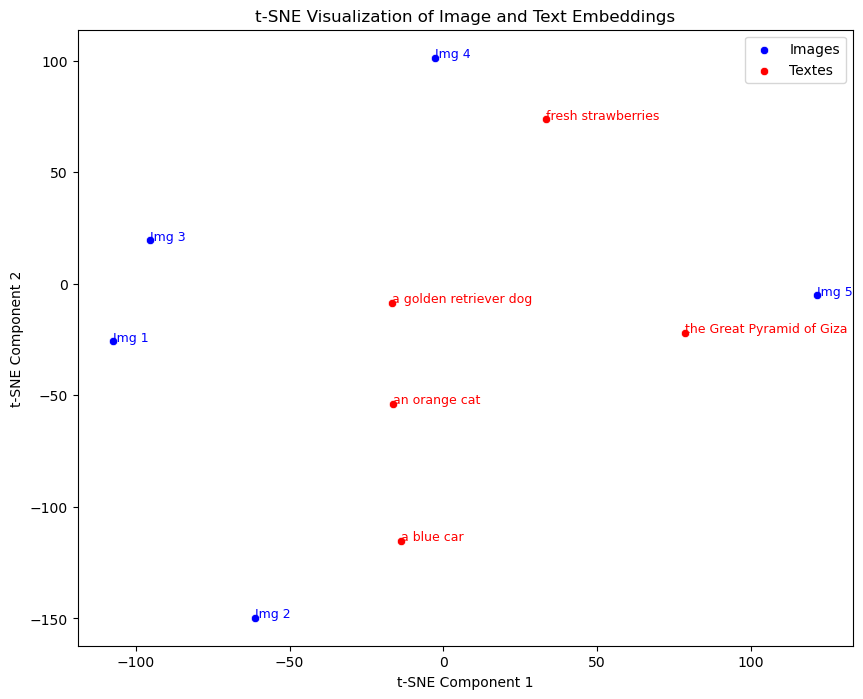

In [14]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import pairwise_distances

def tsne_visualization(image_embeddings, text_embeddings, text_descriptions):
    """
    Visualize image and text embeddings using t-SNE, with text labels and image indices.
    """
    combined_embeddings = np.vstack([image_embeddings, text_embeddings])
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(combined_embeddings)

    tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(combined_embeddings) - 1))
    tsne_result = tsne.fit_transform(scaled_embeddings)

    plt.figure(figsize=(10, 8))

    # Scatter plot pour les images (en bleu)
    sns.scatterplot(
        x=tsne_result[:len(image_embeddings), 0],
        y=tsne_result[:len(image_embeddings), 1],
        label="Images",
        color='blue'
    )

    # Annoter les points images avec leur numéro
    for i in range(len(image_embeddings)):
        plt.annotate(f"Img {i+1}", (tsne_result[i, 0], tsne_result[i, 1]), fontsize=9, color='blue')

    # Scatter plot pour les textes (en rouge)
    sns.scatterplot(
        x=tsne_result[len(image_embeddings):, 0],
        y=tsne_result[len(image_embeddings):, 1],
        label="Textes",
        color='red'
    )

    # Annoter les textes
    for i, txt in enumerate(text_descriptions):
        plt.annotate(txt, (tsne_result[len(image_embeddings) + i, 0], tsne_result[len(image_embeddings) + i, 1]), fontsize=9, color='red')

    plt.title("t-SNE Visualization of Image and Text Embeddings")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend()
    plt.show()

# Appel de la fonction pour visualiser les embeddings
tsne_visualization(image_embeddings, text_embeddings, text_descriptions)


### UMAP

c:\Users\titou\anaconda3\envs\mon_environnement\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\titou\anaconda3\envs\mon_environnement\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


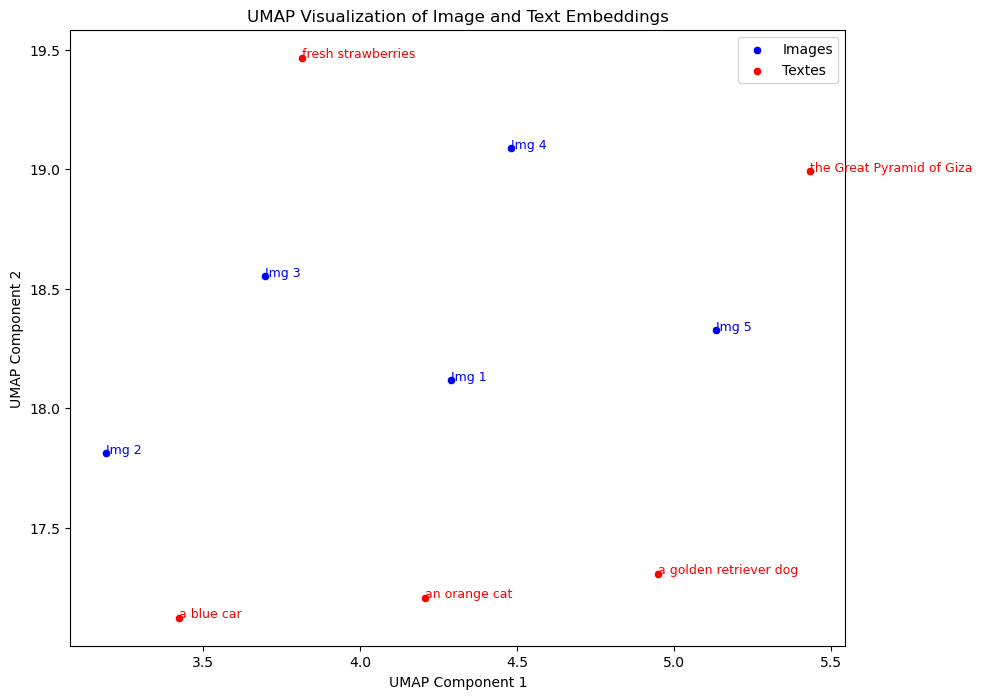

In [15]:
# Methode UMAP
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
import pandas as pd

def umap_visualization(image_embeddings, text_embeddings, text_descriptions):
    """
    Visualize image and text embeddings using UMAP with labels for image indices and text descriptions.
    """
    combined_embeddings = np.vstack([image_embeddings, text_embeddings])
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(combined_embeddings)

    umap_model = umap.UMAP(n_components=2, random_state=42)
    umap_result = umap_model.fit_transform(scaled_embeddings)

    plt.figure(figsize=(10, 8))

    # Scatter plot pour les images (en bleu)
    sns.scatterplot(
        x=umap_result[:len(image_embeddings), 0],
        y=umap_result[:len(image_embeddings), 1],
        label="Images",
        color='blue'
    )

    # Annoter les points images avec leur numéro
    for i in range(len(image_embeddings)):
        plt.annotate(f"Img {i+1}", (umap_result[i, 0], umap_result[i, 1]), fontsize=9, color='blue')

    # Scatter plot pour les textes (en rouge)
    sns.scatterplot(
        x=umap_result[len(image_embeddings):, 0],
        y=umap_result[len(image_embeddings):, 1],
        label="Textes",
        color='red'
    )

    # Annoter les textes
    for i, txt in enumerate(text_descriptions):
        plt.annotate(txt, (umap_result[len(image_embeddings) + i, 0], umap_result[len(image_embeddings) + i, 1]), fontsize=9, color='red')

    plt.title("UMAP Visualization of Image and Text Embeddings")
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")
    plt.legend()
    plt.show()

umap_visualization(image_embeddings, text_embeddings, text_descriptions)


### MLP

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

def train_mlp_model(image_embeddings, text_embeddings, text_descriptions):
    """
    Train a simple MLP model to classify image and text embeddings and evaluate it.
    """
    # Convert embeddings to numpy arrays
    image_embeddings = np.array(image_embeddings)
    text_embeddings = np.array(text_embeddings)

    # Combine image and text embeddings
    combined_embeddings = np.vstack([image_embeddings, text_embeddings])
    
    # Create labels (each description duplicated for image + text)
    labels = np.array(text_descriptions * 2)

    # Encode text labels into numbers
    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels)

    # Split data into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(combined_embeddings, encoded_labels, test_size=0.2, random_state=42)

    # Define MLP model
    class MLPModel(nn.Module):
        def __init__(self, input_size, output_size):
            super(MLPModel, self).__init__()
            self.fc1 = nn.Linear(input_size, 128)
            self.fc2 = nn.Linear(128, 64)
            self.fc3 = nn.Linear(64, output_size)
            self.dropout = nn.Dropout(0.5)

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = self.dropout(x)
            x = torch.relu(self.fc2(x))
            x = self.dropout(x)
            x = self.fc3(x)
            return x

    # Initialisation
    input_size = combined_embeddings.shape[1]
    output_size = len(le.classes_)
    model = MLPModel(input_size, output_size).to(device)

    # Perte + Optimiseur
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Convert data to torch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

    # Entraînement
    num_epochs = 500
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Évaluation
    model.eval()
    with torch.no_grad():
        y_pred_logits = model(X_test_tensor)
        y_pred = torch.argmax(y_pred_logits, dim=1).cpu().numpy()

    y_test_np = y_test  # déjà en numpy

    acc = accuracy_score(y_test_np, y_pred)
    print("\n=== Évaluation du MLP ===")
    print(f"Accuracy : {acc:.4f}")
    print("\nClassification Report :")
    print(classification_report(y_test_np, y_pred, target_names=le.classes_, labels=range(len(le.classes_))))
    print("\nMatrice de Confusion :")
    print(confusion_matrix(y_test_np, y_pred, labels=range(len(le.classes_))))

# Appel de la fonction
train_mlp_model(image_embeddings, text_embeddings, text_descriptions)


Epoch [10/500], Loss: 1.5848
Epoch [20/500], Loss: 1.5588
Epoch [30/500], Loss: 1.4705
Epoch [40/500], Loss: 1.4363
Epoch [50/500], Loss: 1.2189
Epoch [60/500], Loss: 0.8549
Epoch [70/500], Loss: 0.6029
Epoch [80/500], Loss: 0.7010
Epoch [90/500], Loss: 0.5002
Epoch [100/500], Loss: 0.1332
Epoch [110/500], Loss: 0.1812
Epoch [120/500], Loss: 0.1260
Epoch [130/500], Loss: 0.1181
Epoch [140/500], Loss: 0.0551
Epoch [150/500], Loss: 0.0423
Epoch [160/500], Loss: 0.0739
Epoch [170/500], Loss: 0.0669
Epoch [180/500], Loss: 0.0372
Epoch [190/500], Loss: 0.0461
Epoch [200/500], Loss: 0.0424
Epoch [210/500], Loss: 0.0125
Epoch [220/500], Loss: 0.0573
Epoch [230/500], Loss: 0.0127
Epoch [240/500], Loss: 0.0611
Epoch [250/500], Loss: 0.0082
Epoch [260/500], Loss: 0.0266
Epoch [270/500], Loss: 0.0083
Epoch [280/500], Loss: 0.0141
Epoch [290/500], Loss: 0.0051
Epoch [300/500], Loss: 0.0065
Epoch [310/500], Loss: 0.0245
Epoch [320/500], Loss: 0.0044
Epoch [330/500], Loss: 0.0679
Epoch [340/500], Lo

c:\Users\titou\anaconda3\envs\mon_environnement\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\titou\anaconda3\envs\mon_environnement\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\titou\anaconda3\envs\mon_environnement\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi